In [88]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import csv
from IPython.display import display

# =========================== 1. 定义反应物 ===========================

#A-Head
amines = [
    ('CCN(CC)CCN', 'amines_head_1'), # 可继续添加 ('SMILES', '描述')
    ('NCCN1CCCCC1','amines_head_2')
]

#C -Linker
lsocyanides = [   
    ('CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=CC=C2C)C=C1', 'alkynes_tail_1'),
    ('CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=CC(Cl)=C2)C=C1','alkynes_tail_2')
   # ('C#CCCCC(=O)OC(C)CCCCCCCCCC','alkynes_tail_2')
    # 可继续添加
]

#B-tail
aldehydes = [  
    ('CCCCCCCCCCCCOC(=O)CCCCCOC1=CC=C(C=O)C=C1OCCCCCC(=O)OCCCCCCCCCCCC', 'aldehydes_linker_1'),
    ('CCCCCCCCCCCCN(CC=O)CCCCCCCCCCCC','aldehydes_linker_2')
   # ('CCCCCCCCCCCOC(=O)C1=CC=C(C=O)C=C1','aldehydes_linker_2')
    # 可继续添加
]






In [89]:
def process_and_save_products(product_mols, step_name):
    """
    1) 去重 & 转SMILES
    2) 打印SMILES到控制台
    3) 输出到 CSV: f"{step_name}_products.csv"
    4) 在 Notebook 中显示网格图, 并保存到 f"{step_name}_products.png"
    5) 返回去重 & sanitize 后的有效 Mols
    """
    import csv
    from rdkit import Chem
    from rdkit.Chem import Draw
    from IPython.display import display

    if not product_mols:
        print(f"[{step_name}] 没有产物生成.")
        return []

    # 1) 去重并转成 SMILES
    unique_smiles = list(set(Chem.MolToSmiles(m, isomericSmiles=True) for m in product_mols))
    print(f"[{step_name}] 原产物数: {len(product_mols)}, 去重后: {len(unique_smiles)}")

    # 2) 在控制台打印 SMILES
    print(f"[{step_name}] 产物 SMILES 列表 (去重后):")
    for smi in unique_smiles:
        print("  ", smi)

    # 3) 转回 Mol，并进行 Sanitize 检查
    valid_mols = []
    invalid_smiles = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"[警告] 无法从 SMILES 解析: {smi}")
            invalid_smiles.append(smi)
            continue
        try:
            Chem.SanitizeMol(mol)  # RDKit 化学有效性检查
            valid_mols.append(mol)  # 通过的分子
        except Exception as e:
            print(f"[非法产物] SMILES: {smi} | 错误: {e}")
            invalid_smiles.append(smi)

    print(f"[{step_name}] Sanitize 检查后有效产物数: {len(valid_mols)}，非法产物数: {len(invalid_smiles)}")

    # 4) 保存有效产物 CSV
    csv_filename = f"{step_name}_products.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["编号", "SMILES"])
        for idx, mol in enumerate(valid_mols, start=1):
            smi = Chem.MolToSmiles(mol, isomericSmiles=True)
            writer.writerow([idx, smi])
    print(f"[{step_name}] 有效产物 CSV 已保存: {csv_filename}")

    # 5) 保存非法产物 CSV（如果有）
    if invalid_smiles:
        invalid_csv_filename = f"{step_name}_invalid_products.csv"
        with open(invalid_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["SMILES"])
            for smi in invalid_smiles:
                writer.writerow([smi])
        print(f"[{step_name}] 非法产物 CSV 已保存: {invalid_csv_filename}")

    # 6) Notebook 中显示网格图
    if valid_mols:
        img_for_notebook = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img_for_notebook)

        # 7) 可选: 保存 PNG (注释可取消启用)
        # png_filename = f"{step_name}_products.png"
        # img_data = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200), returnPNG=True)
        # with open(png_filename, "wb") as f:
        #     f.write(img_data)
        # print(f"[{step_name}] 图片已保存: {png_filename}")

    return valid_mols  # 返回最终有效分子


In [90]:
# 电荷去除函数
def neutralize_charges(mol):
    if mol is None:
        return None
    patt_replacements = [
        ('[C-]', 'C'),
        ('[N+]', 'N'),
    ]
    smiles = Chem.MolToSmiles(mol)
    for patt, repl in patt_replacements:
        smiles = smiles.replace(patt, repl)
    return Chem.MolFromSmiles(smiles)

反应有效性: False

总产物数: 8
[A3_Coupling] 原产物数: 8, 去重后: 8
[A3_Coupling] 产物 SMILES 列表 (去重后):
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN(CC)CC)[C-]=[N+]C2(c2cccc(Cl)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN3CCCCC3)[C-]=[N+]C2(c2cccc(Cl)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN2CCCCC2)[C-]=[N+]C1(c1ccccc1C)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN2CCCCC2)[C-]=[N+]C1(c1cccc(Cl)c1)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN3CCCCC3)[C-]=[N+]C2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN(CC)CC)[C-]=[N+]C1(c1cccc(Cl)c1)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN(CC)CC)[C-]=[N+]C1(c1ccccc1C)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN(CC)CC)[C-]=[N+]C2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
[A3_Coupling] Sanitize 检查后有效产物数: 8，非法产物数: 0
[A3_Coupling] 有效产物 CSV 已保存: A3

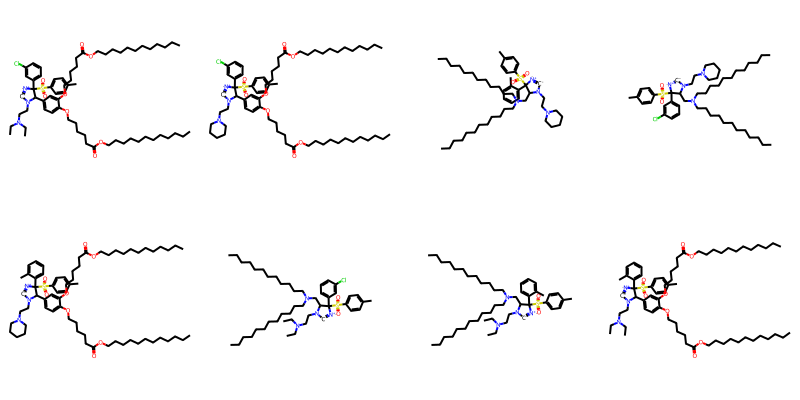

In [91]:
# =========================== 2. 定义反应 SMARTS ===========================

#reaction_smarts = "[NH:1].[CX3H:2]=O[#6].[C:3]#[CH:4]>>[CH:3]#[C:4][C:2][N:1]"
#reaction_smarts = "[NH:1][C:2].[C:3]=O.[C-:4]#[N+:5]>>[N:1]1[C:2]=[C:3]-[N:4]=[C:5]1"
#reaction_smarts = "[NH:1].[CX3H:2]=O.[C:3]#[C:4]>>[N:1][C:2][C:3]#[C:4]"
reaction_smarts = "[NH2:1].[CX3H:2]=O.[C-:3]#[N+:4][C:5]>>[N:1]1[C:2]-[C:5]-[N:4]=[C:3]1"

reaction = AllChem.ReactionFromSmarts(reaction_smarts)
print("反应有效性:", reaction.IsInitialized())  # 检查反应是否被正确识别

# =========================== 3. 存储产物集合 ===========================

product_mols = []

# =========================== 4. 遍历反应 ===========================

for amine_smiles, amine_desc in amines:
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        for lsocyanides_smile, lsocyanide_desc in lsocyanides:  # 正确

            
            # 转Mol对象
            amine = Chem.MolFromSmiles(amine_smiles)
            aldehyde = Chem.MolFromSmiles(aldehyde_smiles)
            lsocyanide = Chem.MolFromSmiles(lsocyanides_smile)  # 正确

            if None in (amine, aldehyde, lsocyanide):
                print(f"[警告] 无效反应物: {amine_desc}, {aldehyde_desc}, {lsocyanide_desc}")
                continue

            # 执行反应
            products = reaction.RunReactants([amine, aldehyde, lsocyanide])

            for product_set in products:
                for product in product_set:
                    try:
                        Chem.SanitizeMol(product)  # 标准化检查
                        product_mols.append(product)  # 收集产物
                    except Chem.AtomValenceException as e:
                        print(f"[非法产物] 跳过: {Chem.MolToSmiles(product)} | 错误: {e}")


print(f"\n总产物数: {len(product_mols)}")


# 调用处理函数
final_unique_products = process_and_save_products(product_mols, "A3_Coupling")




去电荷后的最终产物数: 8
[A3_Coupling_neutralized] 原产物数: 8, 去重后: 8
[A3_Coupling_neutralized] 产物 SMILES 列表 (去重后):
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN2CCCCC2)C=NC1(c1cccc(Cl)c1)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN3CCCCC3)C=NC2(c2cccc(Cl)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2cccc(Cl)c2)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN2CCCCC2)C=NC1(c1ccccc1C)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN(CC)CC)C=NC1(c1ccccc1C)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCN(CCCCCCCCCCCC)CC1N(CCN(CC)CC)C=NC1(c1cccc(Cl)c1)S(=O)(=O)c1ccc(C)cc1
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN3CCCCC3)C=NC2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN(CC)CC)C=NC2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
[A3_Coupling_neutralized] Sanitize 检查后有效产物数: 8，非法产物数: 0
[A3_Coupling_neutralized] 有效产物 CSV 已保存: A3_Coupli

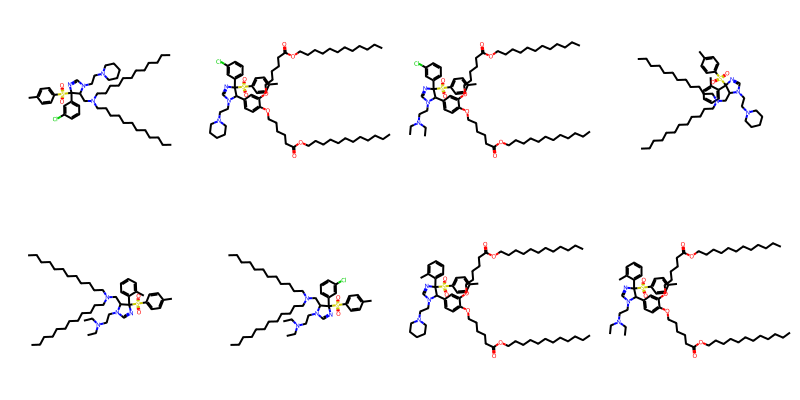

In [92]:
neutralized_final_products = []
for mol in final_unique_products:
    neutral_mol = neutralize_charges(mol)
    if neutral_mol:
        neutralized_final_products.append(neutral_mol)

print(f"\n去电荷后的最终产物数: {len(neutralized_final_products)}")
final_neutralized_products = process_and_save_products(neutralized_final_products, "A3_Coupling_neutralized")


断裂反应有效性: False

断裂反应后总产物数: 16
[Fragmentation_Products] 原产物数: 16, 去重后: 8
[Fragmentation_Products] 产物 SMILES 列表 (去重后):
   CCCCCCCCCCCCN(CCCCCCCCCCCC)Cc1c(-c2cccc(Cl)c2)ncn1CCN1CCCCC1
   CCCCCCCCCCCCN(CCCCCCCCCCCC)Cc1c(-c2ccccc2C)ncn1CCN1CCCCC1
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(-c2c(-c3ccccc3C)ncn2CCN2CCCCC2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCN(CCCCCCCCCCCC)Cc1c(-c2cccc(Cl)c2)ncn1CCN(CC)CC
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(-c2c(-c3cccc(Cl)c3)ncn2CCN(CC)CC)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(-c2c(-c3ccccc3C)ncn2CCN(CC)CC)cc1OCCCCCC(=O)OCCCCCCCCCCCC
   CCCCCCCCCCCCN(CCCCCCCCCCCC)Cc1c(-c2ccccc2C)ncn1CCN(CC)CC
   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(-c2c(-c3cccc(Cl)c3)ncn2CCN2CCCCC2)cc1OCCCCCC(=O)OCCCCCCCCCCCC
[Fragmentation_Products] Sanitize 检查后有效产物数: 8，非法产物数: 0
[Fragmentation_Products] 有效产物 CSV 已保存: Fragmentation_Products_products.csv


[16:44:10] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 7 


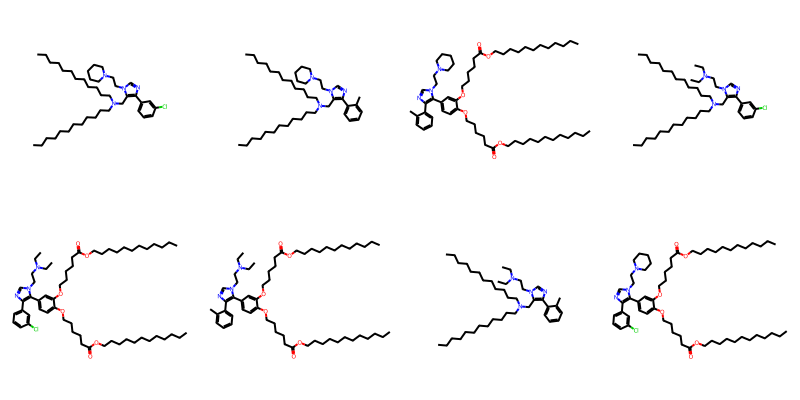

In [93]:
# 1. 定义断裂反应 SMARTS
fragmentation_smarts = "[N:1]1[C:2]-[C:5](-[S:7](=O)(=O)-[*])-[N:4]=[C:3]1>>[N:1]1[C:2]=[C:5]-[N:4]=[C:3]1"
fragmentation_reaction = AllChem.ReactionFromSmarts(fragmentation_smarts)
print("断裂反应有效性:", fragmentation_reaction.IsInitialized())

# 2. 遍历 final_neutralized_products 执行反应
fragment_products = []  # 存储最终产物

for mol in final_neutralized_products:
    if mol is None:
        continue  # 跳过空分子

    # 执行断裂反应
    products = fragmentation_reaction.RunReactants((mol,))

    for product_set in products:
        for product in product_set:
            try:
                Chem.SanitizeMol(product)  # 标准化
                fragment_products.append(product)
            except Chem.AtomValenceException as e:
                print(f"[非法产物] 跳过: {Chem.MolToSmiles(product)} | 错误: {e}")

print(f"\n断裂反应后总产物数: {len(fragment_products)}")

# 3. 保存断裂产物
final_fragment_products = process_and_save_products(fragment_products, "Fragmentation_Products")


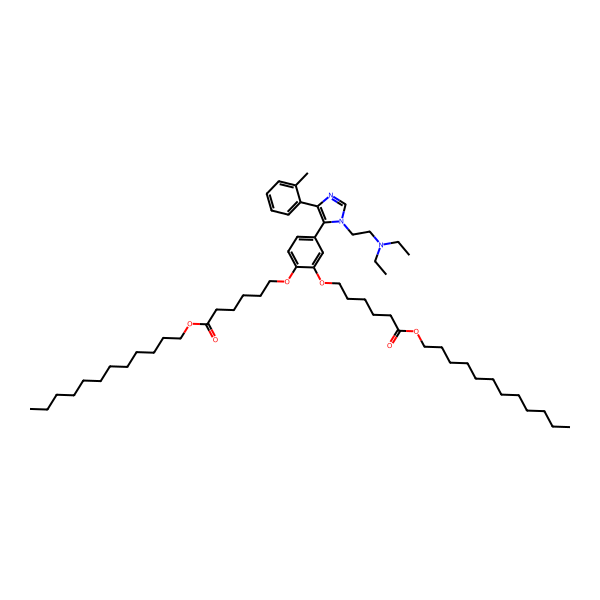

In [83]:
mol13 = Chem.MolFromSmiles("CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(-c2c(-c3ccccc3C)ncn2CCN(CC)CC)cc1OCCCCCC(=O)OCCCCCCCCCCCC", sanitize=True)
mol13
from rdkit.Chem import Draw
Draw.MolToImage(mol13, size=(600,600))


In [ ]:
[C:1]-[S:2](=O)(=O)-[*]

In [ ]:
[N:1]1[C:2]-[C:5]-([S:7](=O)(=O)-[*])-[N:4]=[C:3]1>>[N:1]1[C:2]=[C:5]-[N:4]=[C:3]1

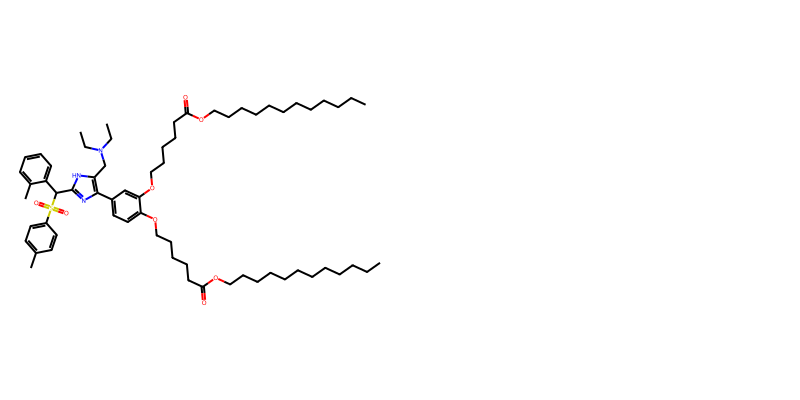

In [25]:
from rdkit.Chem import AllChem, Draw
img = Draw.MolsToGridImage(final_unique_products, molsPerRow=2, subImgSize=(400, 400))
display(img)

In [ ]:
[NH2:1][C:2].[C:3]=O.[C:4][C-:5]#[N+:6]>>[N:1]1[C:2]=[C:3]-[N:4]=[C:5]1

In [ ]:
CCN(CC)CCN

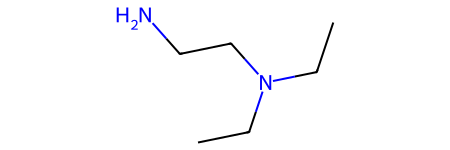

In [26]:
mol13 = Chem.MolFromSmiles("CCN(CC)CCN")
mol13

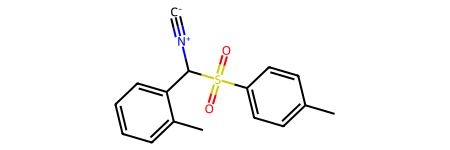

In [19]:
mol14 = Chem.MolFromSmiles("CC1=CC=C(S(=O)(=O)C([N+]#[C-])C2=CC=CC=C2C)C=C1")
mol14

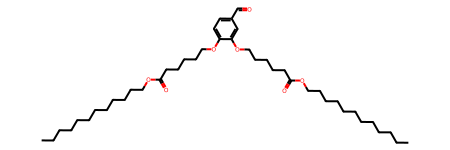

In [20]:
mol13 = Chem.MolFromSmiles("CCCCCCCCCCCCOC(=O)CCCCCOC1=CC=C(C=O)C=C1OCCCCCC(=O)OCCCCCCCCCCCC")
mol13

In [50]:
mol13 = Chem.MolFromSmiles("CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2=C(c3ccccc3C)(S(=O)(=O)c3ccc(C)cc3)[N+]=[C-]N2CCN(CC)CC)cc1OCCCCCC(=O)OCCCCCCCCCCCC",santisize = False)
mol13

ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolFromSmiles(str)
did not match C++ signature:
    MolFromSmiles(boost::python::api::object SMILES, bool sanitize=True, boost::python::dict replacements={})
    MolFromSmiles(boost::python::api::object SMILES, RDKit::v1::SmilesParserParams params)

In [37]:
mol13 = Chem.MolFromSmiles("CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2=C(c3ccccc3C)(S(=O)(=O)c3ccc(C)cc3)[N]=[C]N2)cc1OCCCCCC(=O)OCCCCCCCCCCCC")
mol13

[15:09:02] Explicit valence for atom # 26 C, 5, is greater than permitted


In [39]:
mol13 = Chem.MolFromSmiles("CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C=O)cc1OCCCCCC1(OCCCCCCCCCCCC)=C(c2ccccc2C)(S(=O)(=O)c2ccc(C)cc2)[N]=[C]N1")
mol13

[15:09:26] Explicit valence for atom # 35 C, 5, is greater than permitted


In [ ]:
[非法产物] 跳过:  | 错误: Explicit valence for atom # 1 C, 5, is greater than permitted
[非法产物] 跳过:  | 错误: Explicit valence for atom # 2 C, 5, is greater than permitted
[非法产物] 跳过:  | 错误: Explicit valence for atom # 1 C, 5, is greater than permitted

In [ ]:
[非法产物] 跳过:  | 错误: Explicit valence for atom # 2 C, 5, is greater than permitted


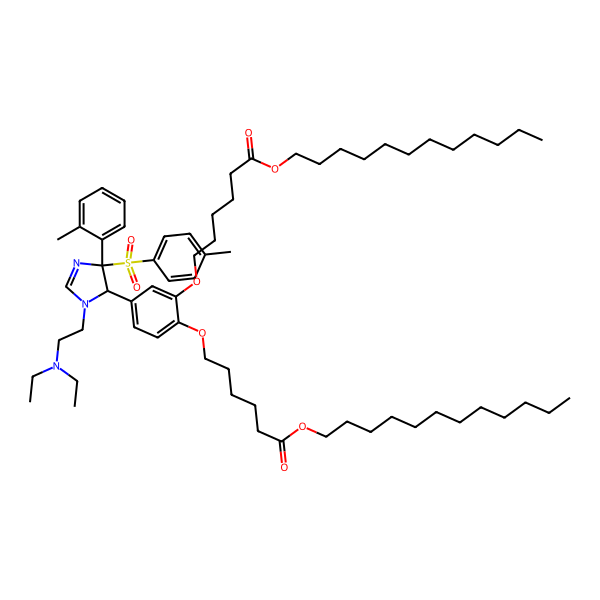

In [74]:
mol13 = Chem.MolFromSmiles("   CCCCCCCCCCCCOC(=O)CCCCCOc1ccc(C2N(CCN(CC)CC)[C]=[N]C2(c2ccccc2C)S(=O)(=O)c2ccc(C)cc2)cc1OCCCCCC(=O)OCCCCCCCCCCCC", sanitize=False)
mol13
from rdkit.Chem import Draw
Draw.MolToImage(mol13, size=(600,600))
